In [1]:
# standard python imports
import os
# import pandas as pd
import torch

# huggingface libraries

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    # HfArgumentParser,
    # TrainingArguments,
    pipeline,
    # logging,
    LlamaForCausalLM
)
from peft import (
#     LoraConfig,
    PeftModel,
#     prepare_model_for_kbit_training,
#     get_peft_model,
)
from datasets import load_dataset, Dataset
# from trl import SFTTrainer, setup_chat_format

# import wandb

import polars as pl
# import pandas as pd

from transformers.pipelines.pt_utils import KeyDataset

In [7]:
def create_prompt(review):
    system_prompt = f"You read student essays reviews and return a score from 0 to 60 that represents your besst guess of the number of rating given by the grader. Return just the number 0, 1, ..., 60 with no context, explanation, or special symbols."
    prompt = f"Here is the review to evaluate: [[[{review}]]]. You read student essays reviews and return a score from 0 to 60 that represents your besst guess of the number of rating given by the grader. Return just the number 0, 1, ..., 60 with no context, explanation, or special symbols."

    return system_prompt, prompt


In [8]:
# df_train = pl.read_csv("../data/1_train_test_split/df_train.csv")
# df_val = pl.read_csv("../data/1_train_test_split/df_validation.csv")

df_val = pl.read_csv("data/imported/val.csv")

In [9]:
lst_system_prompt, lst_prompt = [], []
for row in df_val.iter_rows(named=True):
    system_prompt, prompt = create_prompt(row["text"])
    lst_system_prompt.append(system_prompt)
    lst_prompt.append(prompt)
df_val = df_val.with_columns(pl.Series(lst_system_prompt).alias("system_prompt"), pl.Series(lst_prompt).alias("prompt"))

In [11]:
test_texts = df_val["text"].to_list()
test_labels = df_val["score"].to_list()

data_ = Dataset.from_polars(df_val)

In [ ]:
# !ls /home/richardarcher/Dropbox/Sci24_LLM_Polarization/project_/weights_local/models--meta-llama--Meta-Llama-3.1-8B-Instruct/snapshots/0e9e39f249a16976918f6564b8830bc894c89659

In [12]:
base_model = "/home/richardarcher/Dropbox/Sci24_LLM_Polarization/project_/weights_local/models--meta-llama--Meta-Llama-3.1-8B-Instruct/snapshots/0e9e39f249a16976918f6564b8830bc894c89659"

In [ ]:
# PATH_adapter_custom_weights = "../weights/sft/run01/checkpoint-1034"

In [13]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model,
    tokenizer_file=os.path.join(base_model, 'tokenizer.json'),
    tokenizer_config_file=os.path.join(base_model, 'tokenizer_config.json'),
    special_tokens_map_file=os.path.join(base_model, 'special_tokens_map.json'),
    trust_remote_code=True,
    padding_side='left'
)

tokenizer.padding_side = 'left'

In [14]:
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    # load_in_8bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,  # Match input dtype

)

model = LlamaForCausalLM.from_pretrained(base_model, quantization_config=nf4_config)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# model = PeftModel.from_pretrained(model, PATH_adapter_custom_weights)
# model = model.merge_and_unload() # This line merges the weights

In [15]:
if not tokenizer.pad_token_id:
    tokenizer.pad_token_id = tokenizer.eos_token_id
if model.config.pad_token_id is None:
    model.config.pad_token_id = model.config.eos_token_id

In [16]:
def remove_header(text, K_times):
    for _ in range(K_times):
        if "<|end_header_id|>" in text:
            text = text.split("<|end_header_id|>", 1)[1]
    return text

In [ ]:
# # one at a time (not pipeline; pipeline is next section) (skip to next section for best results)
# 
# pipe = pipeline(
#     "text-generation",
#     model=model,
#     tokenizer=tokenizer,
#     torch_dtype=torch.float16,
#     device_map="auto",
# )
# 
# 
# 
# # # TEST EXAMPLE
# # messages = [
# #     {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
# #     {"role": "user", "content": "Who are you?"},
# # ]
# # 
# # prompt = tokenizer.apply_chat_template(
# #     messages, tokenize=False, add_generation_prompt=True
# # )
# # 
# # outputs = pipe(prompt, max_new_tokens=120, do_sample=True)
# # 
# # cleaned_text = remove_header(outputs[0]["generated_text"], 3).strip()
# # print(cleaned_text)
# 
# df = pl.read_csv("../data/inference_ready/prompts_for_pilot00.csv")
# 
# res = []
# ix = 1
# N = df.shape[0]
# for row in df.iter_rows(named=True):
#     print(f"Now Processing {ix}/{N}")
#     messages = [
#         {"role": "system", "content": row["system_prompt"]},
#         {"role": "user", "content": row["prompt"]},
#     ]
# 
#     prompt = tokenizer.apply_chat_template(
#         messages, tokenize=False, add_generation_prompt=True
#     )
# 
#     outputs = pipe(prompt, max_new_tokens=2_000, do_sample=True)
#     cleaned_text = remove_header(outputs[0]["generated_text"], 3).strip()
#     res.append(cleaned_text)
#     ix = ix + 1

In [17]:
def create_format_chat_template(tokenizer):
    def format_chat_template(row):
        row_json = [{"role": "system", "content": row["system_prompt"]},
                    {"role": "user", "content": row["prompt"]}]

        # row["text"] = tokenizer.apply_chat_template(row_json, tokenize=False)
        row["text"] = tokenizer.apply_chat_template(row_json, tokenize=False, add_generation_prompt=True)
        return row
    return format_chat_template

In [18]:
batch_size = 8

In [19]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    # torch_dtype=torch.float32,
    torch_dtype=torch.float16,
    device_map="auto",
    batch_size=batch_size, # CHANGE TO FOUR IF TOO SLOW
    max_new_tokens=5,
)

In [20]:
data_ = data_.map(
    create_format_chat_template(tokenizer)
)

Map:   0%|          | 0/622 [00:00<?, ? examples/s]

In [21]:
res = []
ix = 0 
for out in pipe(KeyDataset(data_, "text")):
    ix = ix + 1
    if ix % batch_size == 0:
        print(f"{ix}/{data_.shape[0]}")
    
    cleaned_text = remove_header(out[0]["generated_text"], 3).strip()
    res.append(cleaned_text)

8/622
16/622
24/622
32/622
40/622
48/622
56/622
64/622
72/622
80/622
88/622
96/622
104/622
112/622
120/622
128/622
136/622
144/622
152/622
160/622
168/622
176/622
184/622
192/622
200/622
208/622
216/622
224/622
232/622
240/622
248/622
256/622
264/622
272/622
280/622
288/622
296/622
304/622
312/622
320/622
328/622
336/622
344/622
352/622
360/622
368/622
376/622
384/622
392/622
400/622
408/622
416/622
424/622
432/622
440/622
448/622
456/622
464/622
472/622
480/622
488/622
496/622
504/622
512/622
520/622
528/622
536/622
544/622
552/622
560/622
568/622
576/622
584/622
592/622
600/622
608/622
616/622


In [22]:
res_int = [int(i) for i in res]

In [26]:
import numpy as np

In [28]:
a, b = np.array(res_int), np.array(test_labels)

In [29]:
import matplotlib.pyplot as plt

In [32]:
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(a, b)

In [33]:
test_mse

1049.7154340836014

In [34]:
df_val = df_val.with_columns(pl.Series(res_int).alias("8b_quant_prediction"))

In [36]:
df_val.write_csv("data/outputs/8b_quantized_predictions_for_eval_set.csv")

In [39]:
np.corrcoef(a, b)

array([[1.        , 0.03508957],
       [0.03508957, 1.        ]])

(array([411.,  50.,  69.,  27.,  21.,   6.,   6.,  10.,  17.,   5.]),
 array([ 0. ,  4.5,  9. , 13.5, 18. , 22.5, 27. , 31.5, 36. , 40.5, 45. ]),
 <BarContainer object of 10 artists>)

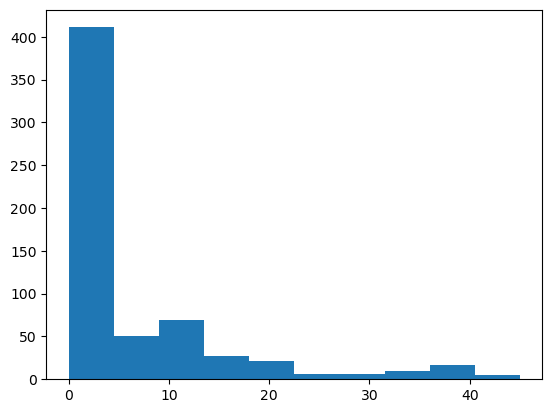

In [42]:
plt.hist(b)

(array([  4.,  20.,  44.,  73.,  42., 121., 113., 116.,  54.,  35.]),
 array([ 4. ,  9.5, 15. , 20.5, 26. , 31.5, 37. , 42.5, 48. , 53.5, 59. ]),
 <BarContainer object of 10 artists>)

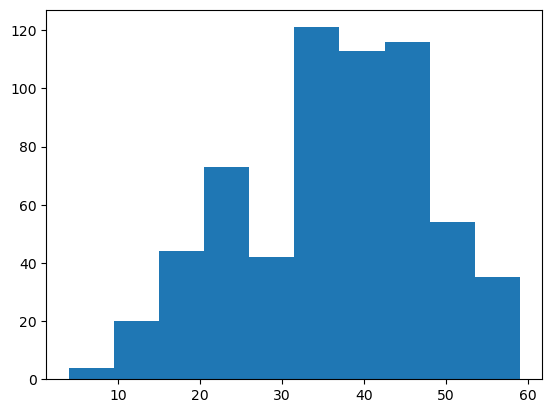

In [41]:
plt.hist(a)